# Test Translation Operators

In [2]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import nmf, proximal, display, proximal_nmf
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

# Translate a test array by integer shifts

In [20]:
def dotTrans(tOp, arr):
    return tOp.dot(arr.flatten()).reshape(arr.shape)
def testIntShift(arr, dx, dy):
    tx, ty, txy = proximal_nmf.getTranslationOps(dx, dy, arr.shape)
    print(arr)
    print(dotTrans(tx.T, arr))
    print(dotTrans(ty, arr))
    print(dotTrans(txy, arr))
arr = np.arange(1,13).reshape(3,4)
print("Shift right 2 and up 1")
testIntShift(arr, 2, 1)
print("Shift left 2 and down 1")
testIntShift(arr, -2, -1)

Shift right 2 and up 1
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
[[  0.   0.   1.   2.]
 [  0.   0.   5.   6.]
 [  0.   0.   9.  10.]]
[[  5.   6.   7.   8.]
 [  9.  10.  11.  12.]
 [  0.   0.   0.   0.]]
[[  0.   0.   5.   6.]
 [  0.   0.   9.  10.]
 [  0.   0.   0.   0.]]
Shift left 2 and down 1
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
[[  3.   4.   0.   0.]
 [  7.   8.   0.   0.]
 [ 11.  12.   0.   0.]]
[[ 0.  0.  0.  0.]
 [ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]]
[[ 0.  0.  0.  0.]
 [ 3.  4.  0.  0.]
 [ 7.  8.  0.  0.]]


# Test Translation on an image with a single pixel by a fractional amount

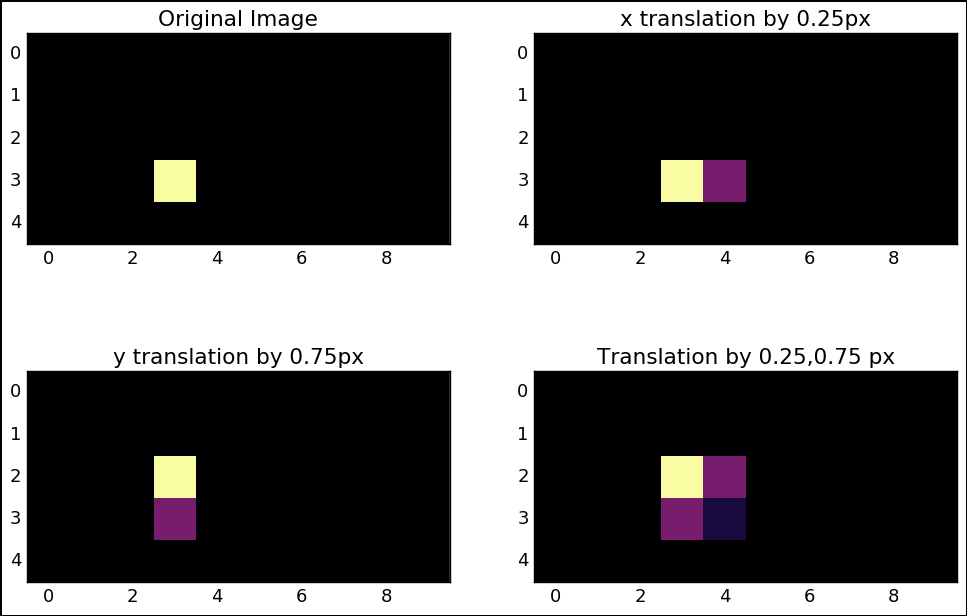

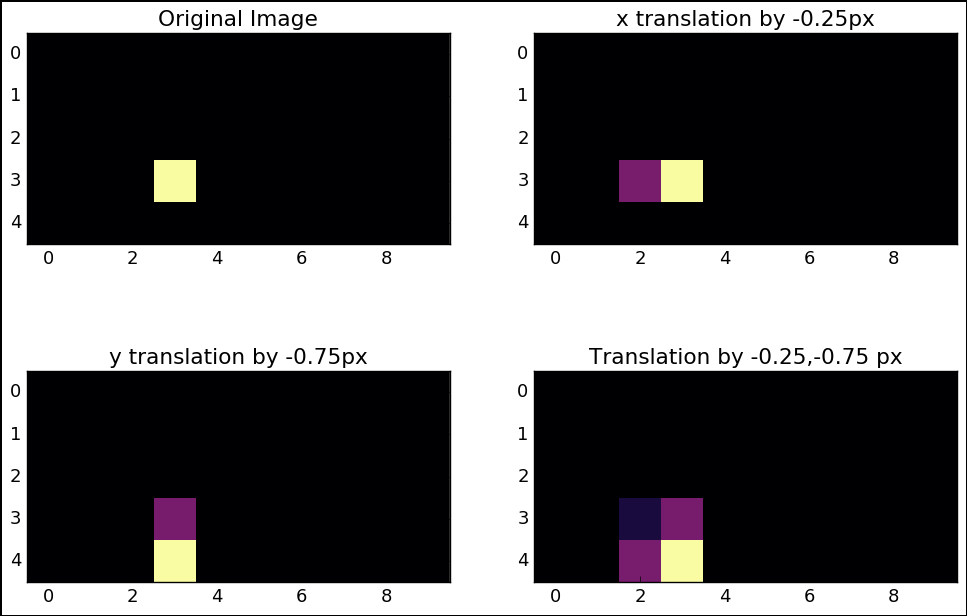

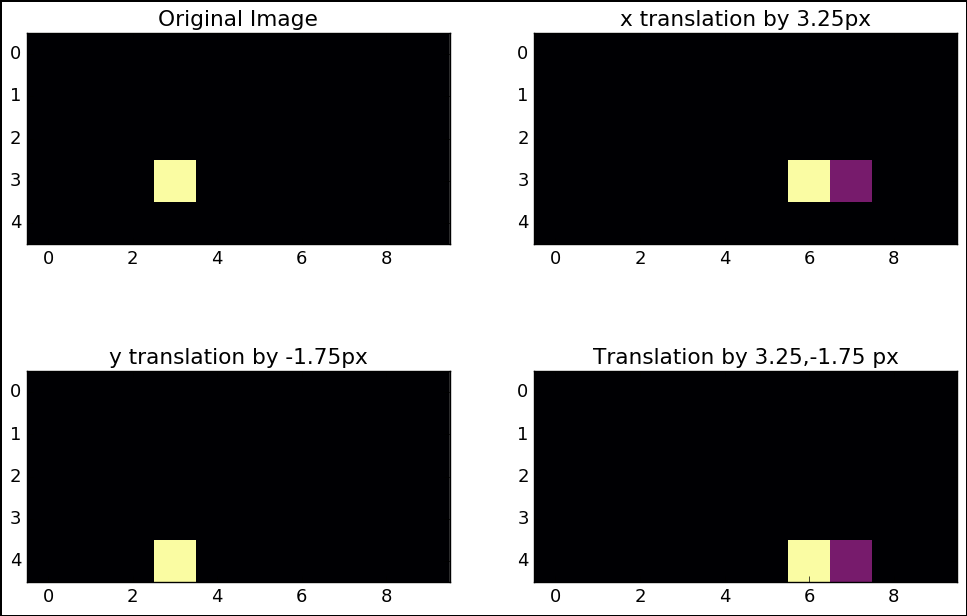

In [46]:
def testFracShift(img, dx, dy, vmin=None, vmax=None):
    tx,ty,txy = proximal_nmf.getTranslationOps(dx, dy, img.shape)
    fig = plt.figure(figsize=(12,8), edgecolor='k', linewidth=1)
    # Show the orignal image
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(img, vmin=vmin, vmax=vmax)
    ax1.set_title("Original Image")
    # Show the image shift in the x direction
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(dotTrans(tx.T, img))
    ax2.set_title("x translation by {0}px".format(dx))
    # Show the image shift in the x direction
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(dotTrans(ty, img))
    ax3.set_title("y translation by {0}px".format(dy))
    # Show the combined image shift
    ax4 = fig.add_subplot(2,2,4)
    ax4.imshow(dotTrans(txy, img))
    ax4.set_title("Translation by {0},{1} px".format(dx, dy))

shape = (5,10)
testImg = np.zeros(shape)
testImg[3,3] = 2

testFracShift(testImg, .25, .75, vmax=2)
testFracShift(testImg, -.25, -.75, vmax=2)
testFracShift(testImg, 3.25, -1.75, vmax=2)

# Test shifting a non-symmetric image by a fractional amount

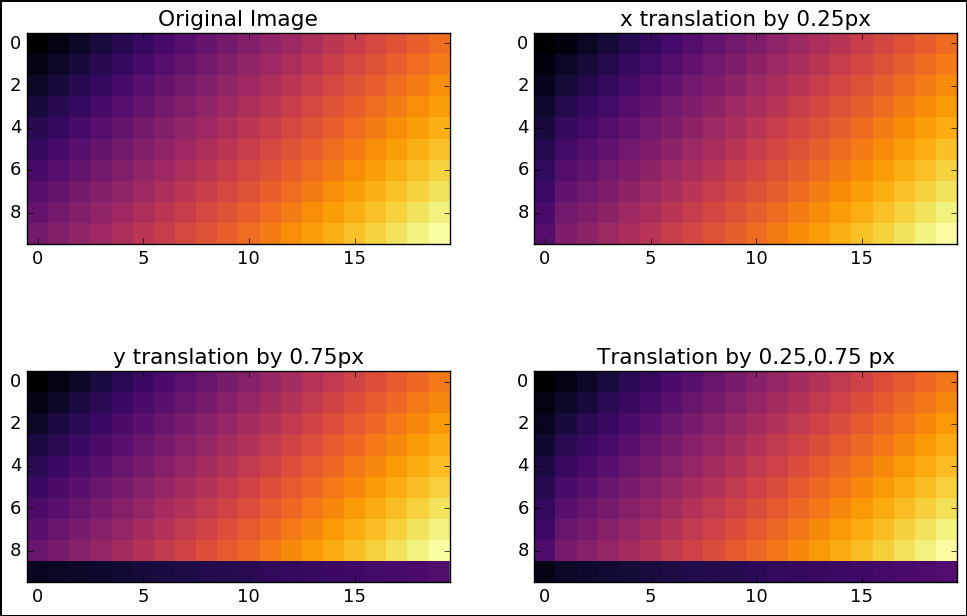

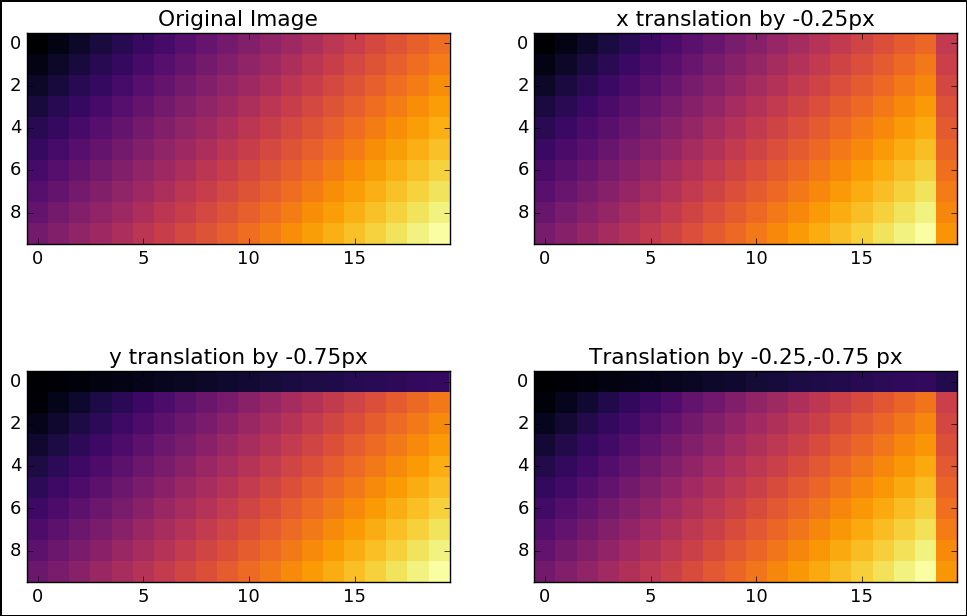

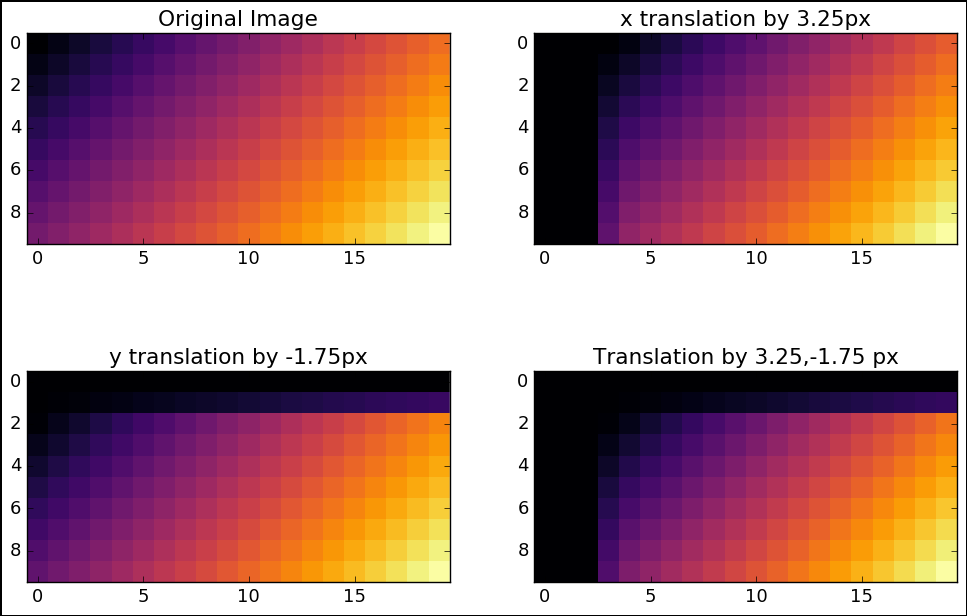

In [40]:
shape = (10,20)
x = np.arange(shape[1])
y = np.arange(shape[0])
x,y = np.meshgrid(x,y)
testImg = x+y
vmax = testImg.max()

testFracShift(testImg, .25, .75, vmax=vmax)
testFracShift(testImg, -.25, -.75, vmax=vmax)
testFracShift(testImg, 3.25, -1.75, vmax=vmax)

# Test shifting a PSF

In [42]:
dataPath = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..','data', 'sim_data'))
filters = ["g","r", "i","z",'y']
imgFilename = os.path.join(dataPath, "test2/{0}_{1}.fits")
catFilename = os.path.join(dataPath, "test2/det_merge.fits")
simFilename = os.path.join(dataPath, "test2/catalog_true.fits")

expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename)

INFO:lsst.meas.deblender.proximal:Total parents: 41
INFO:lsst.meas.deblender.proximal:Unblended sources: 25
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 16


In [43]:
psf = expDb.calexps[0].getPsf().computeImage().getArray()

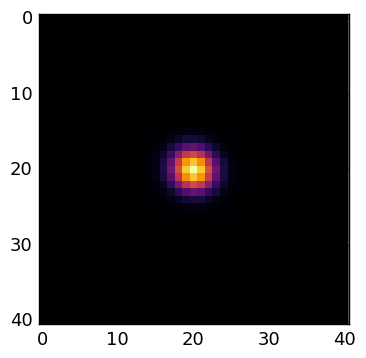

In [44]:
plt.imshow(psf)

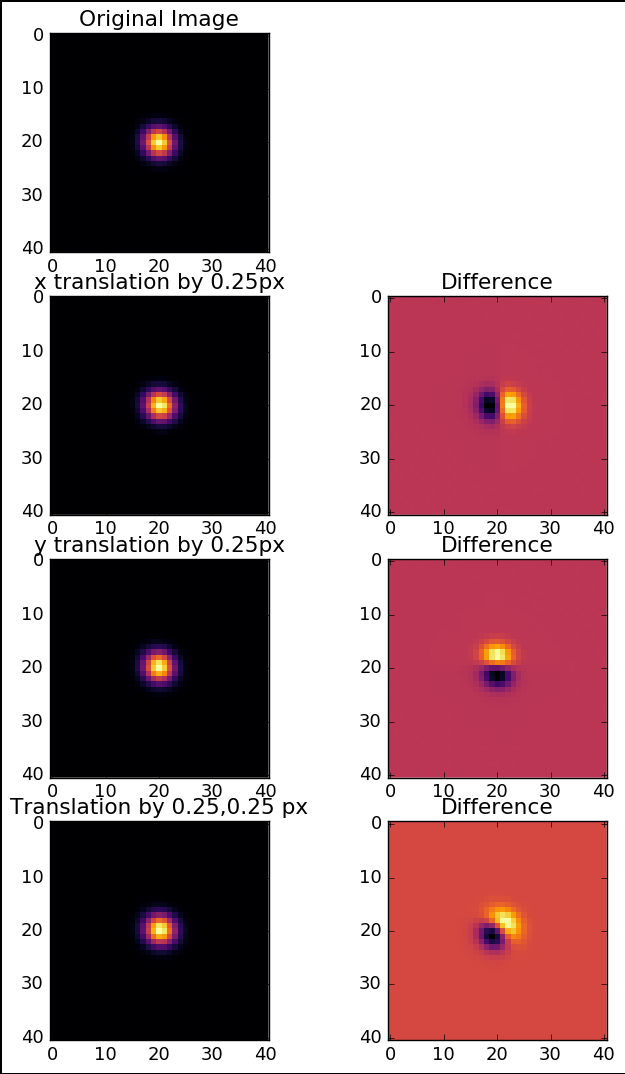

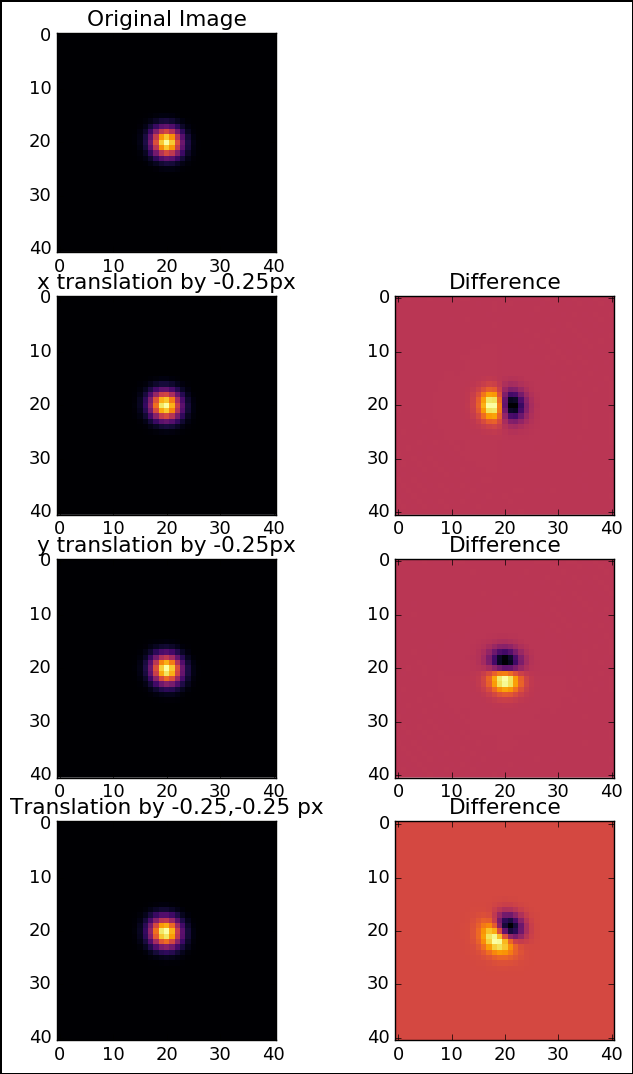

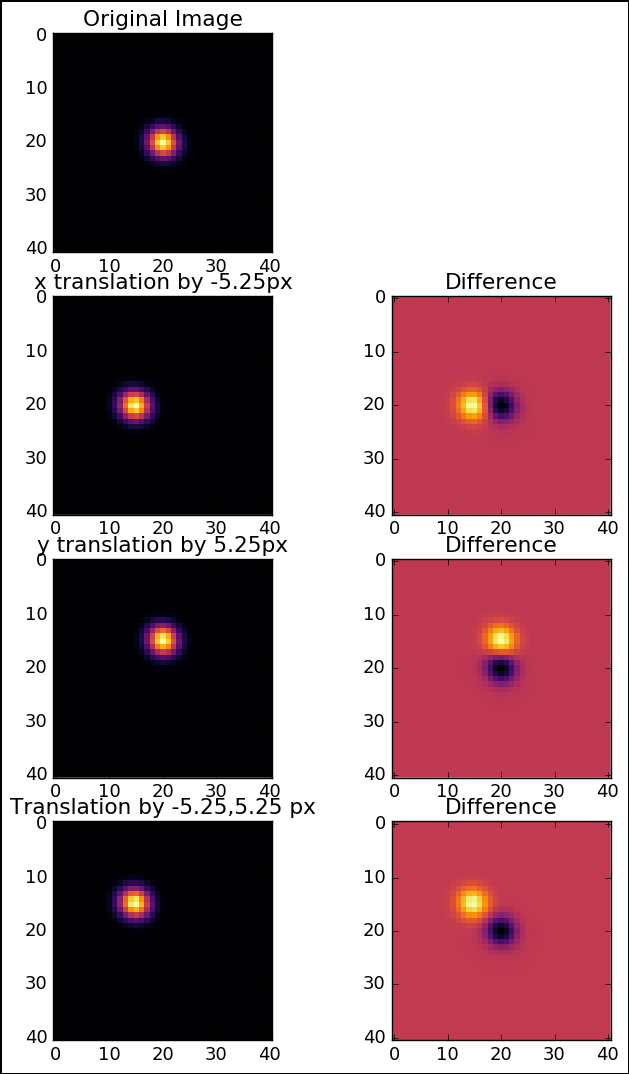

In [54]:
def testPsfShift(img, dx, dy, vmin=None, vmax=None):
    tx,ty,txy = proximal_nmf.getTranslationOps(dx, dy, img.shape)
    fig = plt.figure(figsize=(8,13), edgecolor='k', linewidth=1)
    # Show the orignal image
    ax1 = fig.add_subplot(4,2,1)
    ax1.imshow(img, vmin=vmin, vmax=vmax)
    ax1.set_title("Original Image")
    
    # Show the image shift in the x direction
    ax3 = fig.add_subplot(4,2,3)
    ax3.imshow(dotTrans(tx.T, img))
    ax3.set_title("x translation by {0}px".format(dx))
    # Show the image difference
    ax4 = fig.add_subplot(4,2,4)
    ax4.imshow(dotTrans(tx.T, img)-img)
    ax4.set_title("Difference")
    
    # Show the image shift in the x direction
    ax5 = fig.add_subplot(4,2,5)
    ax5.imshow(dotTrans(ty, img))
    ax5.set_title("y translation by {0}px".format(dy))
    # Show the image difference
    ax6 = fig.add_subplot(4,2,6)
    ax6.imshow(dotTrans(ty, img)-img)
    ax6.set_title("Difference")
    
    # Show the combined image shift
    ax7 = fig.add_subplot(4,2,7)
    ax7.imshow(dotTrans(txy, img))
    ax7.set_title("Translation by {0},{1} px".format(dx, dy))
    # Show the combined image difference
    ax8 = fig.add_subplot(4,2,8)
    ax8.imshow(dotTrans(txy, img)-img)
    ax8.set_title("Difference")
    plt.show()

testPsfShift(psf, .25, .25)
testPsfShift(psf, -.25, -.25)
testPsfShift(psf, -5.25, 5.25)